In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
# data = pd.read_csv('AAPL.csv', index_col='Date',parse_dates=['Date'], date_parser=dateparse)
data = pd.read_csv('AAPL.csv',parse_dates=['Date'], date_parser=dateparse)

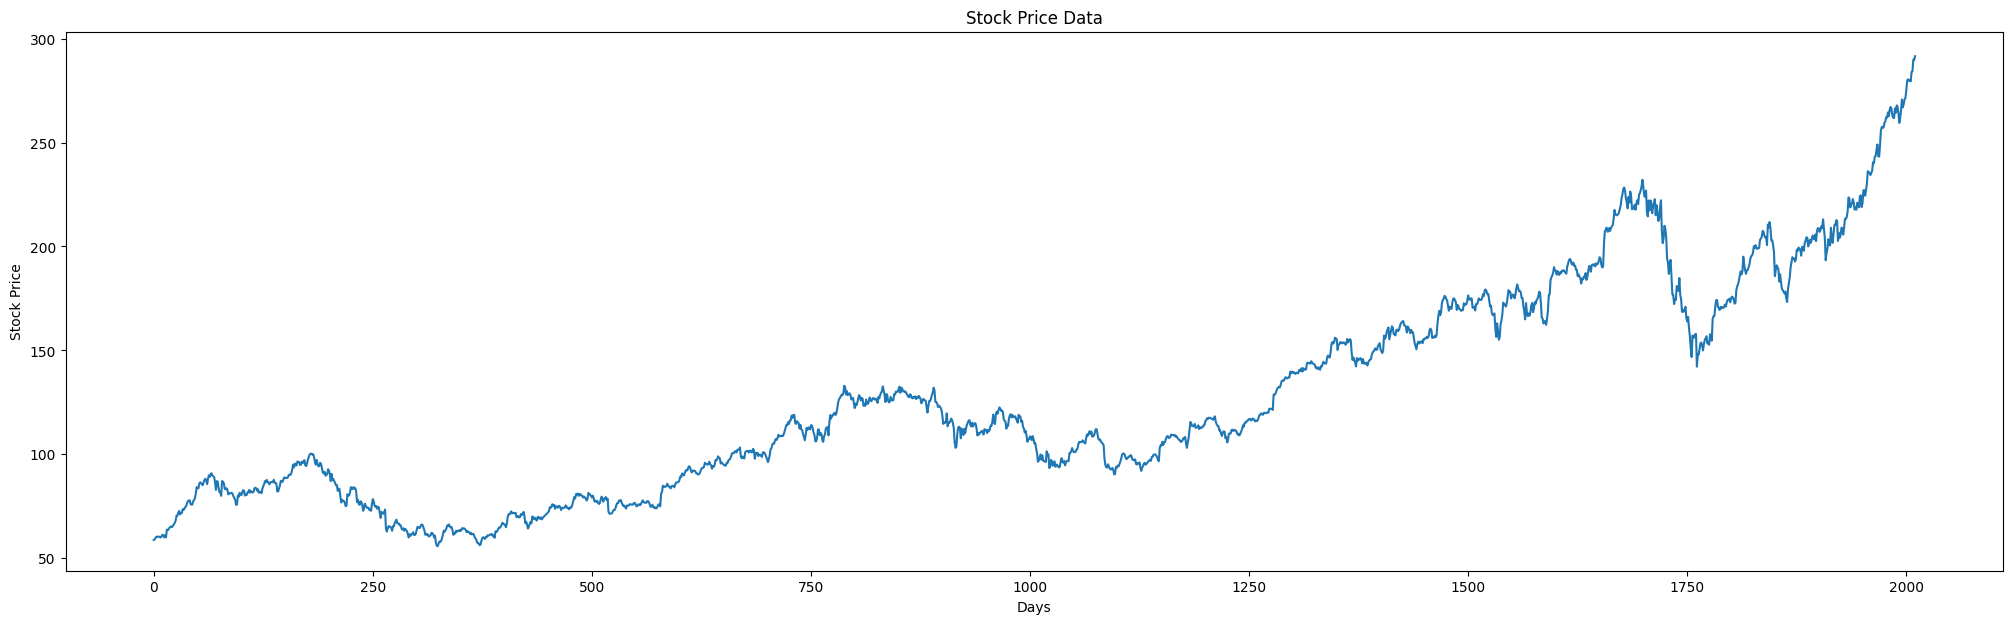

In [3]:
plt.figure(figsize=(25,7))
plt.plot(data["Close"])
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Data')
plt.show()

# ARIMA Model
ARIMA is  short for AutoRegressive Integrated Moving Average, is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
ARIMA Models are specified by three order parameters: (p, d, q), where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

In [4]:
#stationary test
from statsmodels.tsa.stattools import adfuller
result = adfuller(data["Close"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.219370
p-value: 0.996117


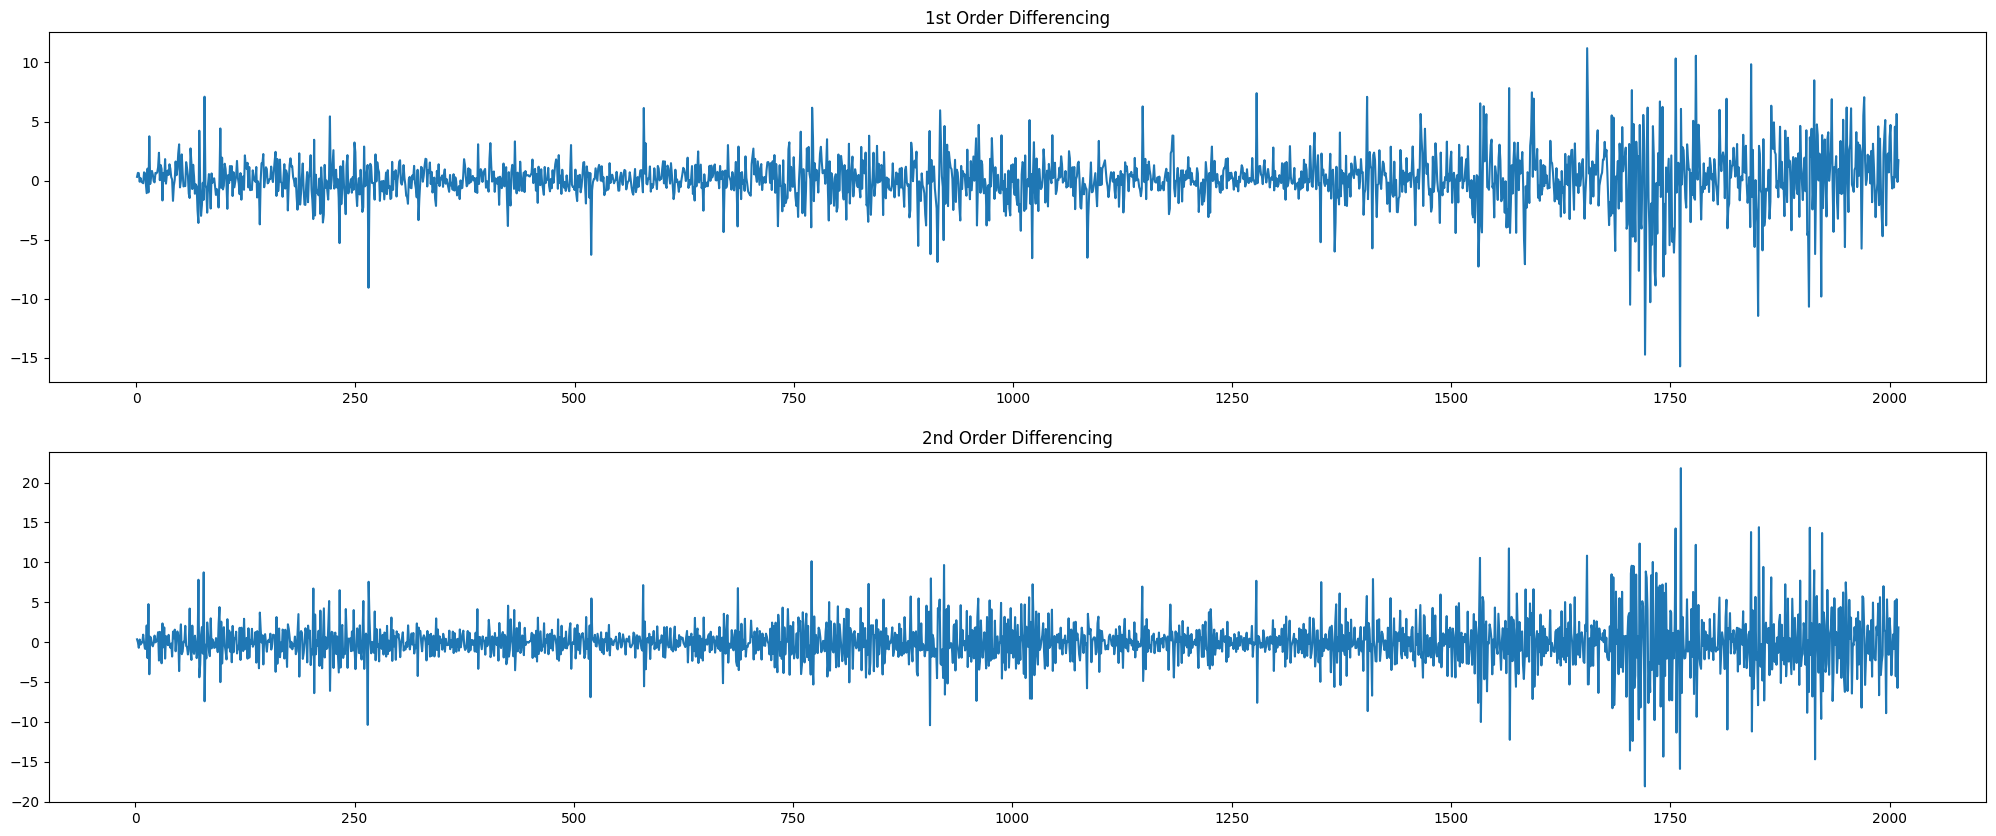

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(25,10))
axes[0].plot(data["Close"].diff()); ax=axes[0].set_title('1st Order Differencing')
axes[1].plot(data["Close"].diff().diff()); ax=axes[1].set_title('2nd Order Differencing')
plt.show()

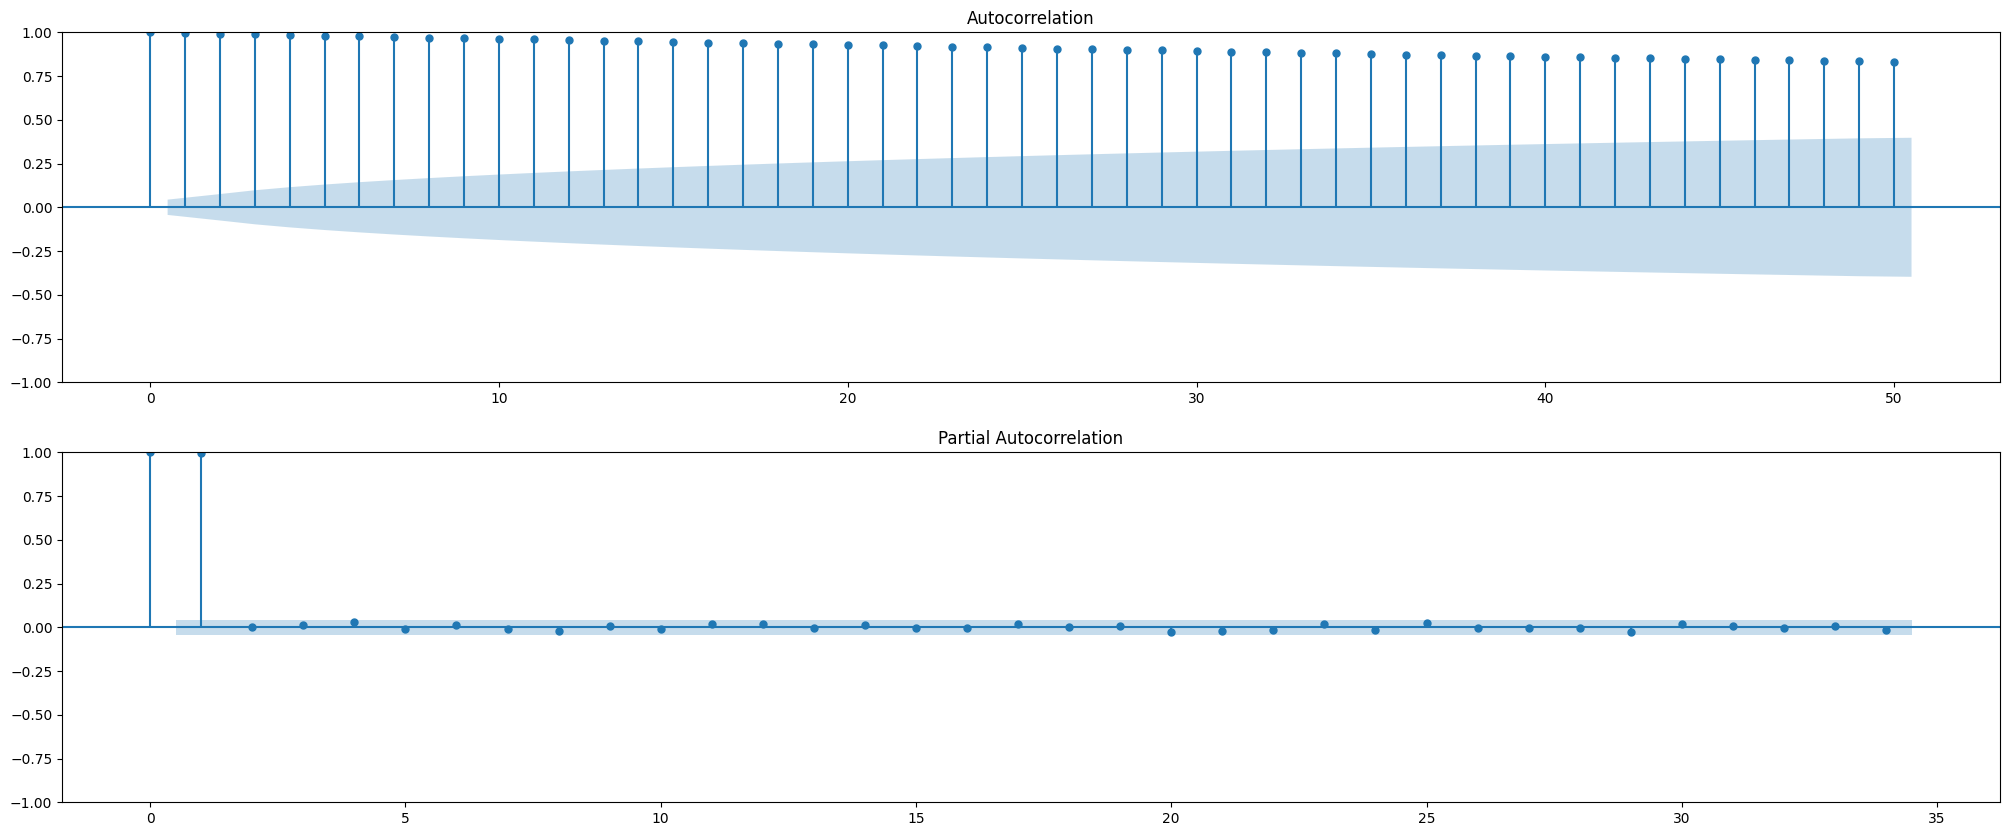

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(25,10))
plot_acf(data["Close"], lags=50, ax=axes[0])
plot_pacf(data["Close"], ax=axes[1])
plt.show()

In [8]:
# Split the data into train and test sets
train_size = int(len(data["Close"]) * 0.9)
train_data, test_data = data["Close"][0:train_size], data["Close"][train_size:]

In [9]:
# Define the range of p, d, and q values to try
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Generate all possible combinations of p, d, and q values
pdq_values = list(itertools.product(p_values, d_values, q_values))

# Fit ARIMA models with each combination of p, d, and q values
best_aic = np.inf
best_pdq = None

for pdq in pdq_values:
    try:
        model = ARIMA(train_data, order=pdq)
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = pdq
    except:
        continue

print('Best (p, d, q) values: {}'.format(best_pdq))

Best (p, d, q) values: (2, 1, 2)


In [10]:
# Fit the ARIMA model
model_arima = ARIMA(train_data, order=(2, 1, 2))
arima_fit = model_arima.fit()

In [11]:
# Predict the stock price for the test data
predictions_arima = arima_fit.forecast(steps=len(test_data))

In [12]:
# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions_arima)
print("Mean Squared Error: ", mse)
# Calculate MAPE
mape = np.mean(np.abs((test_data - predictions_arima) / test_data)) * 100
print("MAPE:", mape)

Mean Squared Error:  2165.2271513625906
MAPE: 15.31457384836368


In [13]:
predictions_arima

1809    181.669627
1810    182.278087
1811    182.880239
1812    182.832769
1813    182.191449
           ...    
2006    182.196603
2007    182.511144
2008    182.572656
2009    182.317385
2010    182.020536
Name: predicted_mean, Length: 202, dtype: float64

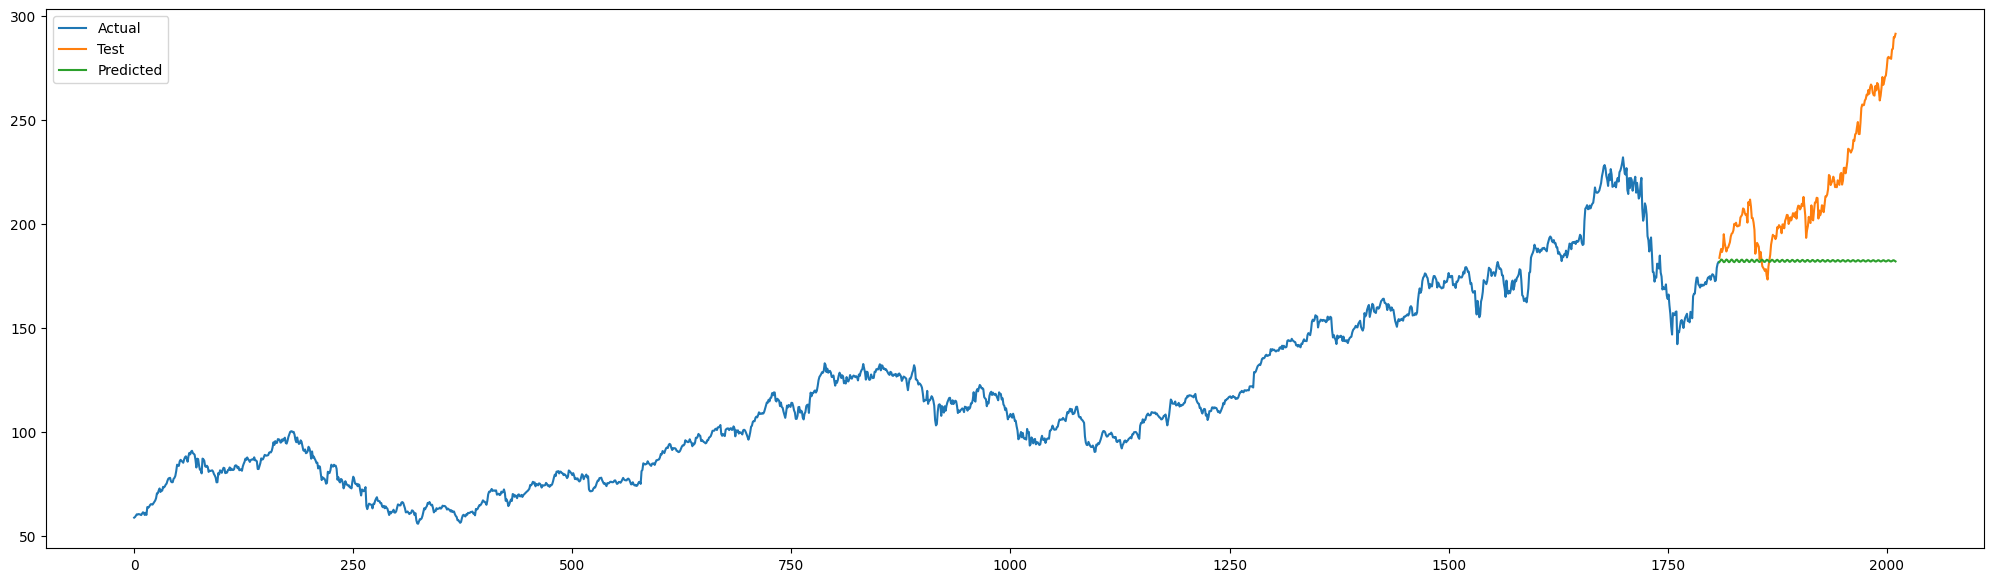

In [14]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(25,7))
plt.plot(train_data, label="Actual")
plt.plot(test_data, label="Test")
plt.plot(predictions_arima, label="Predicted")
plt.legend()
plt.show()

In [15]:
model_sarima = SARIMAX(train_data, order=(2,1,2), seasonal_order=(2,1,2,12))
sarima_fit = model_sarima.fit()

In [16]:
# predictions_sarima = sarima_fit.forecast(steps=30)
# Predict the stock price for the test data
predictions_sarima = sarima_fit.forecast(steps=len(test_data))

In [17]:
# Calculate the mean squared error
mse = mean_squared_error(test_data, predictions_sarima)
print("Mean Squared Error: ", mse)
# Calculate MAPE
mape = np.mean(np.abs((test_data - predictions_sarima) / test_data)) * 100
print("MAPE:", mape)

Mean Squared Error:  1562.4639242340957
MAPE: 12.786891135309075


In [19]:
predictions_sarima

1809    181.378937
1810    181.479797
1811    181.661387
1812    181.610764
1813    181.649758
           ...    
2006    194.972910
2007    195.150715
2008    195.253291
2009    195.246953
2010    195.357049
Name: predicted_mean, Length: 202, dtype: float64

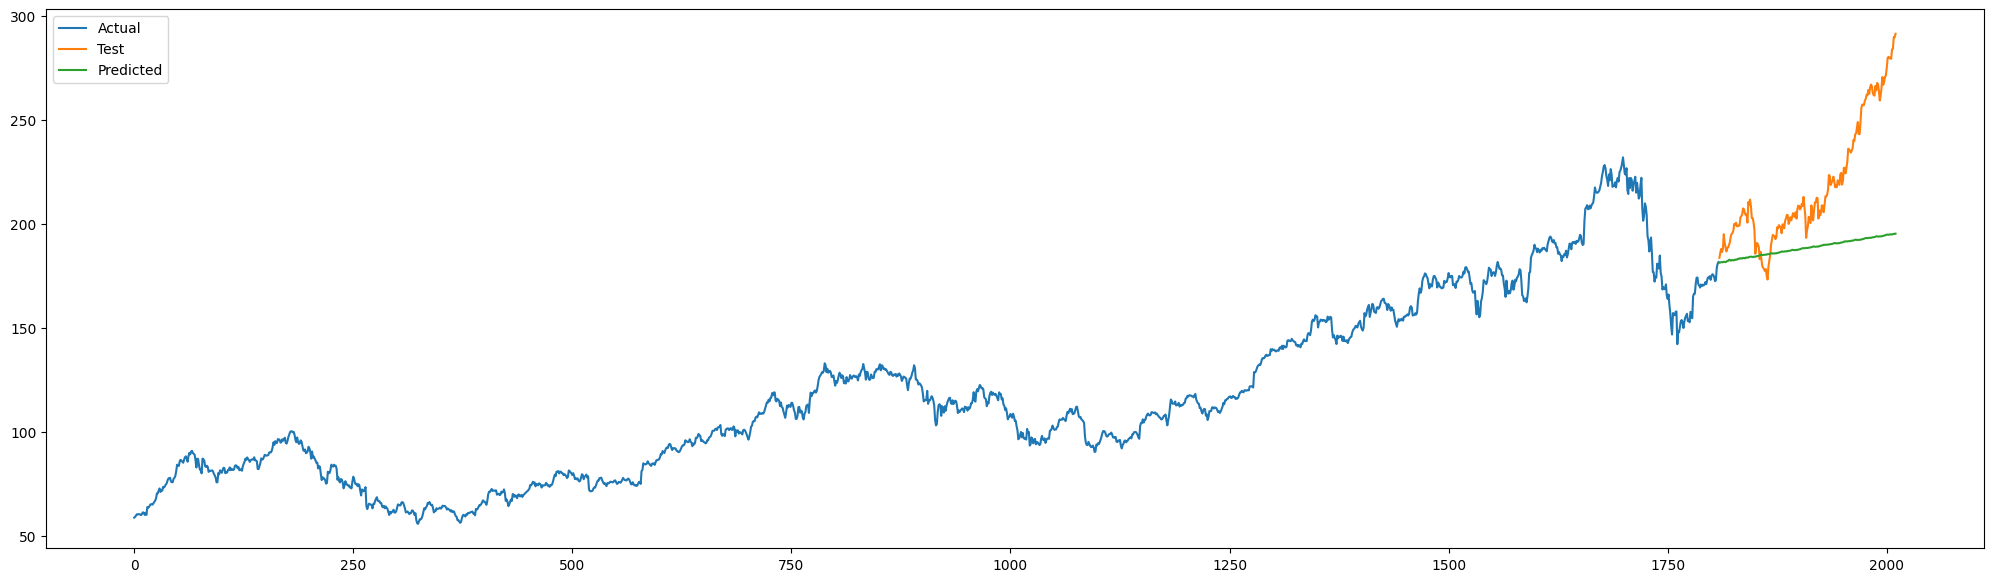

In [20]:
# Plot the actual vs predicted stock prices
plt.figure(figsize=(25,7))
plt.plot(train_data, label="Actual")
plt.plot(test_data, label="Test")
plt.plot(predictions_sarima, label="Predicted")
plt.legend()
plt.show()

In [23]:
import pickle

In [25]:
filename = 'model_sarima.sav'
pickle.dump(model_sarima, open(filename, 'wb'))